# 2DGaussian Fitting PBCOR

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube, Projection
from astropy.modeling import models, fitting
from astropy.convolution import convolve_models
from astropy import units as u
from astropy.io import fits
import radio_beam
from radio_beam import Beam
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

/Users/galagabits/miniconda3/envs/masers/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Accessing Cube Data
def fit_2dgaussian(directory, maser_table, freq, amplitude, x, y, x_stddev, y_stddev, theta=np.pi/3, size=13, channel=0, cube=True, format='fits', table=True):

    if cube:
        
        cube = SpectralCube.read(directory, format=format)

        if channel is None:
            pass
        else:
            cube = cube[channel,:,:]

        cube_cutout = cube[y - size:y + size, x - size:x + size]
        yy, xx = cube_cutout.spatial_coordinate_map

        cord = cube.world[y,x]

        x_guess, y_guess = cord[1], cord[0]

    else:
        
        hdul = fits.open(directory)

        hdu = hdul[0]

        data_cube = hdul[0].data

        if data_cube.ndim == 4:
            data = data_cube[0, 0, :, :] * u.Jy/u.beam

        else:
            data = hdu.data * u.Jy/u.beam

        header = hdu.header

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            ww = WCS(header).celestial

        data_cutout = data[y - size:y + size, x - size:x + size]
        ypixel_grid, xpixel_grid = np.mgrid[y - size:y + size, x - size:x + size]
        
        xx, yy = ww.pixel_to_world_values(xpixel_grid, ypixel_grid)

        xx = (xx * u.deg)
        yy = (yy * u.deg)

        x_guess, y_guess = xx[size, size], yy[size, size]

        cube_cutout = data_cutout


    p_init_gauss2D = models.Gaussian2D(x_mean=x_guess, y_mean=y_guess, amplitude=amplitude * (u.Jy/u.beam),
                                    x_stddev=(x_stddev), y_stddev=(y_stddev), theta=(theta)*u.rad)

    fit_p = fitting.LevMarLSQFitter()

    cube_cutout_quant = cube_cutout

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        p_gauss2D = fit_p(p_init_gauss2D, xx, yy, cube_cutout_quant)

    p_init_gauss2D.theta.fixed = True

    cov = np.diag(fit_p.fit_info['param_cov'])
    errors = np.sqrt(cov)

    amplitude_error=np.format_float_scientific(errors[0],precision=9)
    x_mean_error=np.format_float_scientific(errors[1],precision=9)
    y_mean_error=np.format_float_scientific(errors[2],precision=9)
    x_stddev_error=np.format_float_scientific(errors[3],precision=9)
    y_stddev_error=np.format_float_scientific(errors[4],precision=9)
    theta_error=np.format_float_scientific(errors[5],precision=9)

    amplitude = np.format_float_scientific(p_gauss2D.amplitude[0],precision=9)
    x_mean = np.format_float_scientific(p_gauss2D.x_mean[0],precision=9)
    y_mean = np.format_float_scientific(p_gauss2D.y_mean[0],precision=9)
    x_stddev = np.format_float_scientific(p_gauss2D.x_stddev[0],precision=9)
    y_stddev = np.format_float_scientific(p_gauss2D.y_stddev[0],precision=9)
    theta = np.format_float_scientific(p_gauss2D.theta[0],precision=9)

                
    plt.figure(figsize=(20, 6))
    plt.suptitle(f"Source-CA3 freq-{freq}", fontsize=18)

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(cube_cutout.value, origin='lower', cmap='inferno')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Model")
    plt.imshow(p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("Residual")
    plt.imshow(cube_cutout.value - p_gauss2D(xx, yy).value, origin='lower', cmap='inferno')
    plt.colorbar(label='S (Jy)')

    plt.show()

    print("Parameter" + ' ' + 'Error' +"\n")
    print("Amplitude" +"\n")
    print(amplitude + ' ' + amplitude_error +"\n")

    print("x_mean"  +"\n")
    print(x_mean + ' ' + x_mean_error +"\n")

    print("y_mean" +"\n")
    print(y_mean + ' ' + y_mean_error +"\n")

    print("x_stddev" +"\n")
    print(x_stddev + ' ' + x_stddev_error +"\n")

    print("y_stddev" +"\n")
    print(y_stddev + ' ' + y_stddev_error +"\n")

    print("theta" +"\n")
    print(theta + ' ' + theta_error +"\n")

    # print('\n\nSkyCoord Conversion \n----------------- \n')
    # print("Parameter" + ' ' + 'Error' +"\n")
    
    if table:
        new_row = pd.DataFrame({'freq': [freq], 'x_pix': [x], 'y_pix': [y], 'amplitude': [amplitude], 'amplitude_error': [amplitude_error], 'x_mean': [x_mean], 'x_mean_error': [x_mean_error], 'y_mean': [y_mean], 'y_mean_error': [y_mean_error]})
        maser_table = pd.concat([maser_table, new_row], ignore_index=True)

        return maser_table

#### VLA Ka-band ( 1 cm =  GHz) continuum ICRS
`/orange/adamginsburg/w51/vla/19A-254/derod/W51_North_KabandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal2.image.tt0.pbcor.fits`

In [39]:
ca3_positions = pd.DataFrame(columns=['freq', 'x_pix', 'y_pix', 'amplitude', 'amplitude_error', 'x_mean', 'x_mean_error', 'y_mean', 'y_mean_error'])

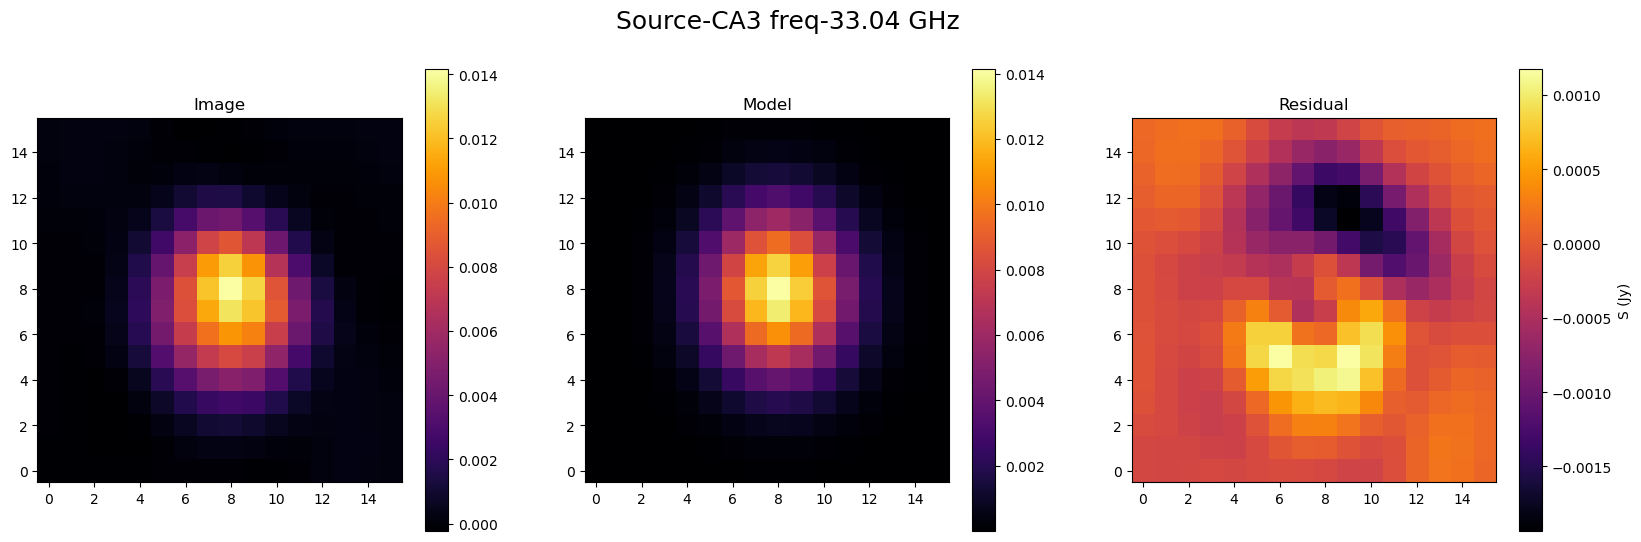

Parameter Error

Amplitude

1.417646378e-02 9.630693979e-04

x_mean

2.909159075e+02 1.711859068e-07

y_mean

1.451800485e+01 1.979477588e-07

x_stddev

8.765088729e-06 1.711888606e-07

y_stddev

1.014322661e-05 1.980821024e-07

theta

3.094106511e+00 9.347586324e-02



In [40]:
directory3 = '/Volumes/GalagaResearch/Developer/masers/continuum/originals/W51_North_KabandAarray_cont_spws_continuum_cal_clean_2terms_robust0_selfcal2.image.tt0.pbcor.fits'

ca3_positions = fit_2dgaussian(table=True, cube=False, directory=directory3, 
                                          maser_table=ca3_positions,
                                          amplitude=0.05, x=5219, y=4960, x_stddev=0.032 * u.arcsec, y_stddev=0.037 * u.arcsec, theta=np.pi, 
                                          size=8, freq='33.04 GHz')